# Exercise sheet 3

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import rankdata
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

###### Reference: https://en.wikipedia.org/wiki/Pearson_correlation_coefficient
### Function Name: pearson_coefficient: 
##### Parameter: Data for correlation
   The Pearson correlation coefficient (PCC) is a measure of the linear correlation between two variables X and Y. PCC or 'r' has a value between +1 and −1

\begin{align}
r = \frac{\sum _{i=1}^{n}(x_{i}-{\bar {x}})(y_{i}-{\bar {y}})}{\sqrt {{\sum _{i=1}^{n}}(x_{i}-{\bar {x}})^2}\sqrt {{\sum _{i=1}^{n}}(y_{i}-{\bar {y}})^2}} \\
\end{align}

###### Reference: https://statistics.laerd.com/statistical-guides/pearson-correlation-coefficient-statistical-guide.php
    
    Assumptions:
        1.The variables must be either interval or ratio measurements.
        2.The variables must be approximately normally distributed.
        3.There is a linear relationship between the two variables
        4.Outliers are either kept to a minimum or are removed entirely.
        5.There is homoscedasticity of the data.


In [2]:
def pearson_coefficient(x,y):
    x = x - np.mean(x)
    y = y - np.mean(y)
    return (np.sum(x*y)/np.sqrt(np.sum(x*x)*np.sum(y*y)))
    

###### Reference: https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient
### Function Name: spearman_rank_coefficient: 
##### Parameter: Data for correlation
   The Spearman's rank-order correlation is the nonparametric version of the Pearson product-moment correlation. Spearman's correlation coefficient, (ρ, also signified by rs) measures the strength and direction of association between two ranked variables.



\begin{align}
r_{s} = \rho_{rg_{X},rg_{Y}} = \frac{cov(rg_{x},rg_{y})}{\sigma_{rg_{X},rg_{Y}}}\\
\end{align}

###### Reference: https://statistics.laerd.com/statistical-guides/spearmans-rank-order-correlation-statistical-guide.php
    
    Assumption:   You need two variables that are either ordinal, interval or ratio

In [3]:
def spearman_rank_coefficient(x,y):
    rank_x = rankdata(x)
    rank_y = rankdata(y)
    
    return pearson_coefficient(rank_x,rank_y)

### Function Name: read_data
##### Parameter: Filename,column names
This function reads the data and returns the data with its headers

In [4]:
def read_data(filename,columns,delimit):
    if columns == None:
        data = pd.read_csv(filename, sep='\s+', delimiter = delimit)
        return data
    data = pd.read_csv(filename, sep='\s+',header = None)
    data.columns = columns
    return data

### Function Name: check_na_null
##### Parameter: dataframe, column names

This function checks the presence of null or NA values within the dataset

In [5]:
def check_na_null(data):
    data.isnull().values.any()
    data.dropna(inplace = True)
    data = pd.get_dummies(data=data)
    return data

In [6]:
def text_to_number(data,column):
    for i in column:
        data[i] = pd.Categorical(data[i])
        data[i] = data[i].cat.codes
    return data

###### Reference: http://mathworld.wolfram.com/FrobeniusNorm.html
### Function name: normalise_data
###### Parameters: data to be normalised

numpy.linalg.norm function returns the normalisation of a matrix. By default, it returns Forbenius Norm of a matrix

\begin{align}
{A}_{norm} = \sqrt{\sum_{i=1}^m\sum_{j=1}^n |A_{i,j}|^2} \\
\end{align}

In [7]:
def normalise_data(data):
    norm_data = data.copy()
    for columns in norm_data:
        norm_data[columns] = norm_data[columns]/np.linalg.norm(norm_data[columns])
    return norm_data

def denormalise_data(data,norm_data):
    denorm_data = norm_data.copy()
    denorm = np.linalg.norm(data[str(data.columns[-1])])
    for i in range (0,len(norm_data)):
        for j in range (0,len(norm_data[i])):
            denorm_data[i][j] = norm_data[i][j] * denorm
    return denorm_data

In [8]:
def RMSE(y_data,y_pred):
    return np.sqrt(np.sum(pow((y_data - y_pred),2)))/len(y_pred)

### Function Name: create_Test_Train_data
### Parameter: Data of input variables and target
This function splits the input variables and target data to Train and Test data with 80% and 20% of the data respectively

In [9]:
def create_Test_Train_data(X_data,Y_data):
    Y_train = Y_data[:math.ceil(0.8*len(Y_data))]
    Y_test = Y_data[math.ceil(0.8*len(Y_data)):]
    X_train = X_data[:math.ceil(0.8*len(X_data))]
    X_test = X_data[math.ceil(0.8*len(X_data)):]
    return Y_train,Y_test,X_train,X_test

#### Bold driver step length for controlling the learning rate

\begin{align}
\mu = \mu.\mu^{+}\\
\mu = \mu.\mu^{-}
\end{align}

In [10]:
def bold_steplength(alpha,f_new,f_old):
    
    alpha_plus = 1.1
    alpha_minus = 0.5
    if f_new < f_old:
        alpha = alpha * alpha_plus
    else:
        alpha = alpha * alpha_minus
    return alpha

#### Adagrad steplength controller

\begin{align}
\beta_{new} = \beta_{old} - \frac{\mu}{\sqrt{h}}G\\
G = X^{T}(y-p)\\
h = {h + G*G}
\end{align}

In [11]:
def adagrad_steplength(alpha,beta,xtr,ytr,history):
    error =  ytr - 1/(1 + np.exp(-np.dot(beta,xtr.T)))
    grad = - (xtr.T * error)
    grad_sq = np.dot(grad, grad.T)
    print(grad_sq)
    for i in range(0,len(history)):
        history[i] += float(grad_sq[i][i]) + 1e-10
        beta[i] = beta[i] - float((alpha/np.sqrt(history[i])) 
                                  * grad[i])
    
    return beta,history

In [12]:
def linalg_prediction(beta,data,ttype):
    if ttype == 'Test':
        X = np.ones((data.shape[0],data.shape[1]+1))
        X[:,1:] = data
        return np.dot(beta,X.T)
    else:
        return np.dot(beta,data.T)

#### To perform linear regression on the data

In [13]:
def linridgereg_mini_bgd(alpha,beta,minibatchsize,reg,Y_train,Y_test,X_train,X_test,steplength_type):
    X = np.insert(X_train, 0, 1, axis = 1)
    rmse_train = []
    rmse_test = []
    epochs = 150
    batches = math.ceil(len(X)/minibatchsize)
    for iteration in range(0,epochs):
        for i in range(0,batches):
            if i*50+50 < len(X):
                
                batch_X = X[i*50:i*50+50]
                batch_Y = Y_train[i*50:i*50+50]
            else:
                
                batch_X = X[i*50:]
                batch_Y = Y_train[i*50]
            Y_prediction = linalg_prediction(beta,batch_X,'Train')
            error = Y_prediction - batch_Y
            func_gradient = 2 * np.dot(batch_X.T,error)
            beta = beta - alpha * (func_gradient)
            Y_prediction = linalg_prediction(beta,batch_X,'Train')
            error = Y_prediction - batch_Y
        if (steplength_type == "Bold"):
            alpha = bold_steplength(alpha,likelihood_new,likelihood)
        rmsetrain = RMSE(batch_Y,Y_prediction)
        rmsetest = RMSE(Y_test,linalg_prediction(beta,X_test,'Test'))
        rmse_train.append(rmsetrain)
        rmse_test.append(rmsetest)
    return rmse_train,rmse_test,beta

#### Perform Linear regression with Gradient Descent

In [14]:
def linridgereg_gd(Y_train,Y_test,X_train,X_test,alpha,reg,minibatchsize,ttype):
    initialbeta = np.zeros(X_data.shape[1] + 1)
    train_graph = list()
    test_graph = list()
    if ttype != 'Tune':
        for i in range(0,len(reg)):
            for j in range(0,len(alpha)):
                rmse_train,rmse_test,beta = linridgereg_mini_bgd(alpha[j],initialbeta,minibatchsize,reg[i],Y_train,Y_test,X_train,X_test,None)
                train_graph.append(rmse_train)
                test_graph.append(rmse_test)
        return train_graph,test_graph
    else:
        rmse_train,rmse_test,beta = linridgereg_mini_bgd(alpha,initialbeta,minibatchsize,reg,Y_train,Y_test,X_train,X_test,None)
        return rmse_train,rmse_test
        

## Wine dataset

In [15]:
filename = "./Dataset/winequality-red.csv"
columns = None
redwinedata = read_data(filename,columns,';')
redwinedata = redwinedata.sample(frac = 1)
redwinedata.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
706,7.0,0.780,0.08,2.0,0.093,10.0,19.0,0.99560,3.40,0.47,10.0,5
67,6.6,0.705,0.07,1.6,0.076,6.0,15.0,0.99620,3.44,0.58,10.7,5
1089,11.6,0.410,0.54,1.5,0.095,22.0,41.0,0.99735,3.02,0.76,9.9,7
382,8.3,0.260,0.42,2.0,0.080,11.0,27.0,0.99740,3.21,0.80,9.4,6
589,10.2,0.290,0.49,2.6,0.059,5.0,13.0,0.99760,3.05,0.74,10.5,7


In [16]:
redwinedata_correlation = []
Correlation = pd.DataFrame(index=np.arange(0, 1), columns=redwinedata.columns )
for column in redwinedata:
    if column != "quality":
        Correlation[column] = (str(round(pearson_coefficient
                                                 (np.array(redwinedata[column]),np.array(redwinedata["quality"])),4)))
Correlation

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0.1241,-0.3906,0.2264,0.0137,-0.1289,-0.0507,-0.1851,-0.1749,-0.0577,0.2514,0.4762,NaN


In [17]:
Required_redwinedata = redwinedata.drop(columns = ['residual sugar','free sulfur dioxide','pH','fixed acidity','chlorides','total sulfur dioxide'])
                                #,'Avg_Fare1','Avg_Fare2','Mrkt_Share1','Mrkt_Share2'])
Required_redwinedata.head()

,volatile acidity,citric acid,density,sulphates,alcohol,quality
706,0.780,0.08,0.99560,0.47,10.0,5
67,0.705,0.07,0.99620,0.58,10.7,5
1089,0.410,0.54,0.99735,0.76,9.9,7
382,0.260,0.42,0.99740,0.80,9.4,6
589,0.290,0.49,0.99760,0.74,10.5,7


In [18]:
Required_redwinedata = normalise_data(Required_redwinedata)
Required_redwinedata.head()

,volatile acidity,citric acid,density,sulphates,alcohol,quality
706,0.034998,0.005995,0.024979,0.017295,0.023869,0.021962
67,0.031633,0.005246,0.024994,0.021342,0.025539,0.021962
1089,0.018396,0.040469,0.025023,0.027966,0.023630,0.030746
382,0.011666,0.031476,0.025024,0.029438,0.022436,0.026354
589,0.013012,0.036722,0.025029,0.027230,0.025062,0.030746


In [19]:
Y_data = np.array(Required_redwinedata.quality)
Required_redwinedata = Required_redwinedata.drop(columns = 'quality')
X_data = np.array(Required_redwinedata)
Y_train,Y_test,X_train,X_test = create_Test_Train_data(X_data,Y_data)

print("Xtrain: " ,X_train.shape)
print("Ytrain: " ,Y_train.shape)
print("Xtest: " ,X_test.shape)
print("Ytest: " ,Y_test.shape)

Xtrain:  (1280, 5)
Ytrain:  (1280,)
Xtest:  (319, 5)
Ytest:  (319,)


#### Calling Linear regression using Gradient descent function

In [92]:
alpha = [1e-4,1e-5,1e-3]
reg = [9e-6,1e-10,1e-3]
# alpha = [1e-5]
# reg = [9e-6]
minibatchsize = 50
train_graph = list()
test_graph = list()
train_graph,test_graph = linridgereg_gd(Y_train,Y_test,X_train,X_test,alpha,reg,minibatchsize,None)
train_graph = denormalise_data(redwinedata,train_graph)
test_graph = denormalise_data(redwinedata,test_graph)


In [93]:
alpha = [1e-4,1e-5,1e-6,1e-4,1e-5,1e-6,1e-4,1e-5,1e-6]
reg = [9e-6,9e-6,9e-6,1e-10,1e-10,1e-10,1e-3,1e-3,1e-3]

IndexError: list index out of range

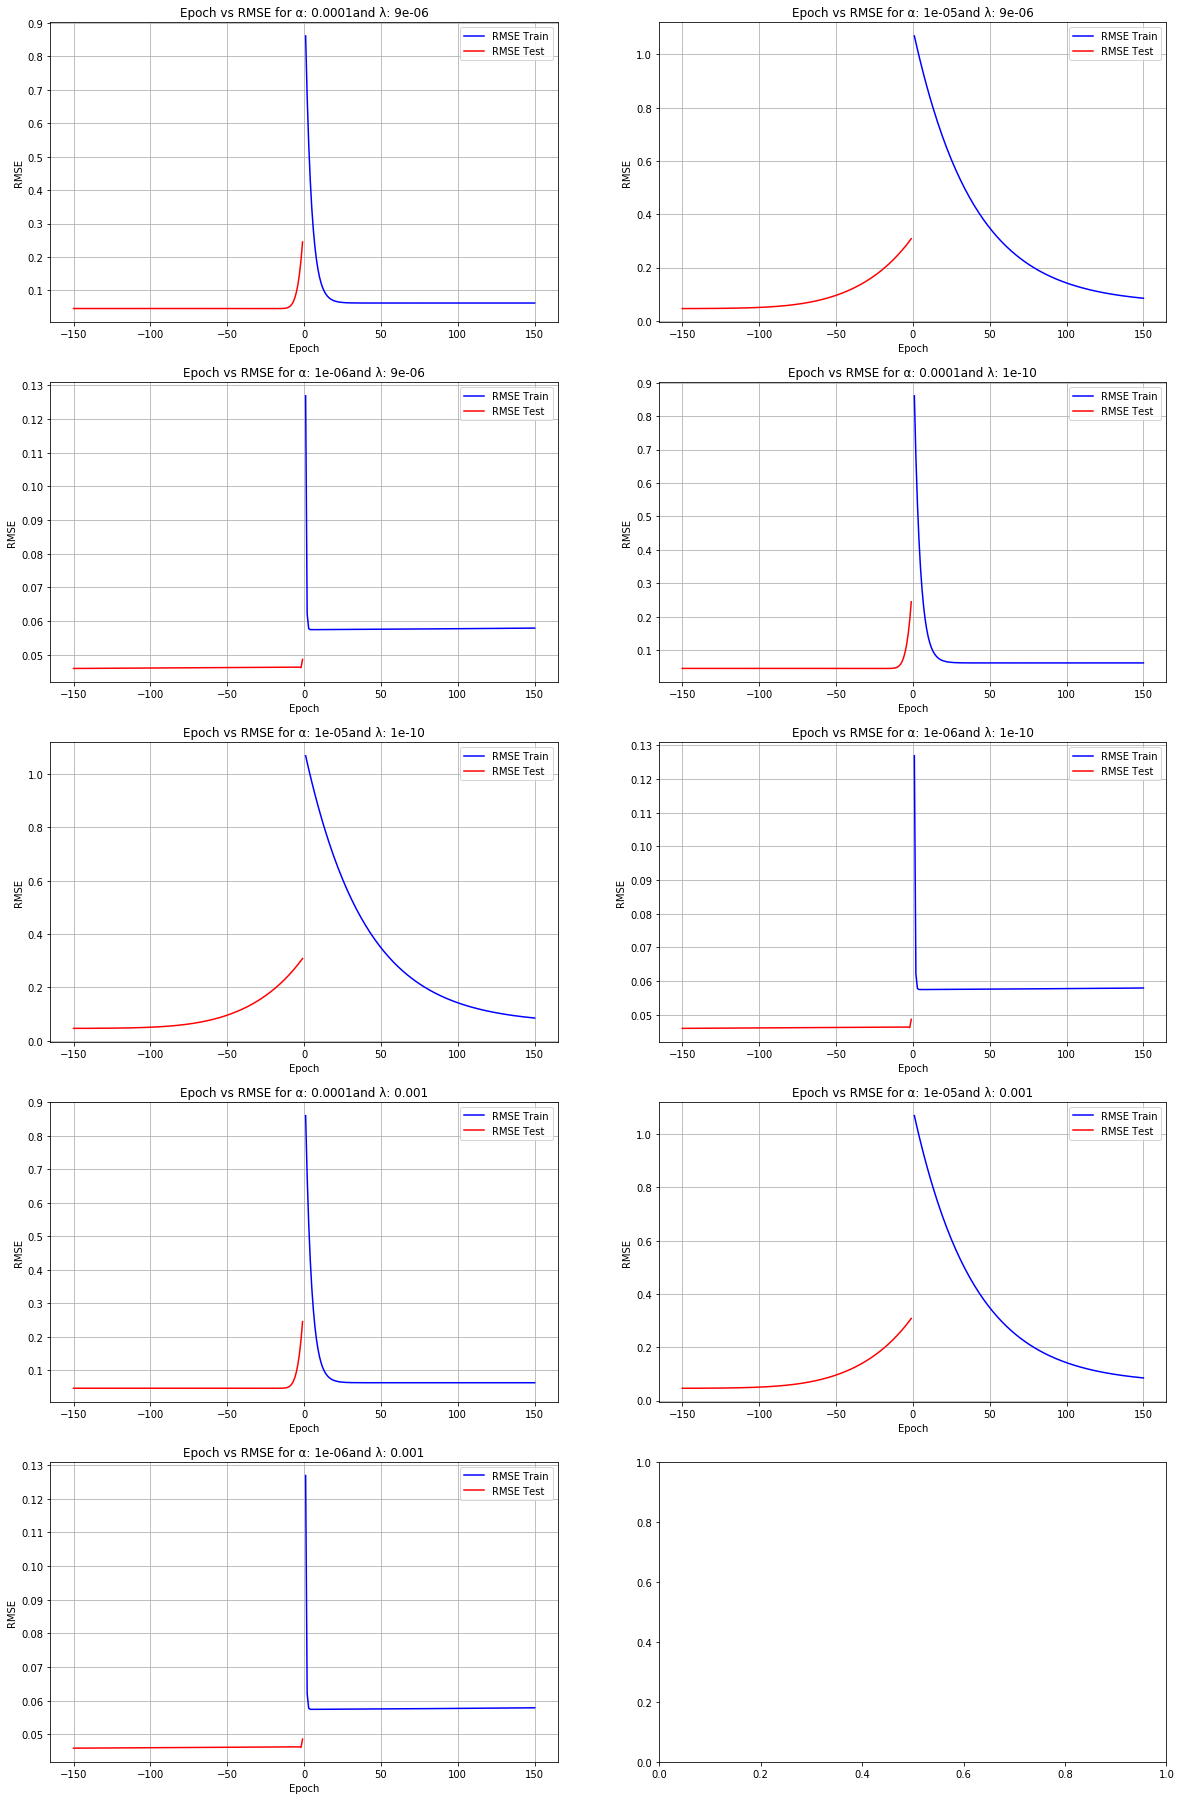

In [94]:
negrange = -np.arange(1,len(test_graph[0])+1)
posrange = np.arange(1,len(test_graph[0])+1)
fig, axs = plt.subplots(5, 2, figsize=(20, 32))
i = 0
for axis in range(0,5):
    axs[axis][0].set_title('Epoch vs RMSE for α: '+str(alpha[i])+'and λ: '+str(reg[i]))
    axs[axis][0].plot(posrange,train_graph[i],'b',label = 'RMSE Train')
    axs[axis][0].plot(negrange,test_graph[i],'r',label='RMSE Test')
    axs[axis][0].grid()
    axs[axis][0].set_xlabel("Epoch")
    axs[axis][0].set_ylabel("RMSE")
    axs[axis][0].legend()
    i+=1
    axs[axis][1].set_title('Epoch vs RMSE for α: '+str(alpha[i])+'and λ: '+str(reg[i]))
    axs[axis][1].plot(posrange,train_graph[i],'b',label = 'RMSE Train')
    axs[axis][1].plot(negrange,test_graph[i],'r',label='RMSE Test')
    axs[axis][1].grid()
    axs[axis][1].set_xlabel("Epoch")
    axs[axis][1].set_ylabel("RMSE")
    axs[axis][1].legend()
    i+=1

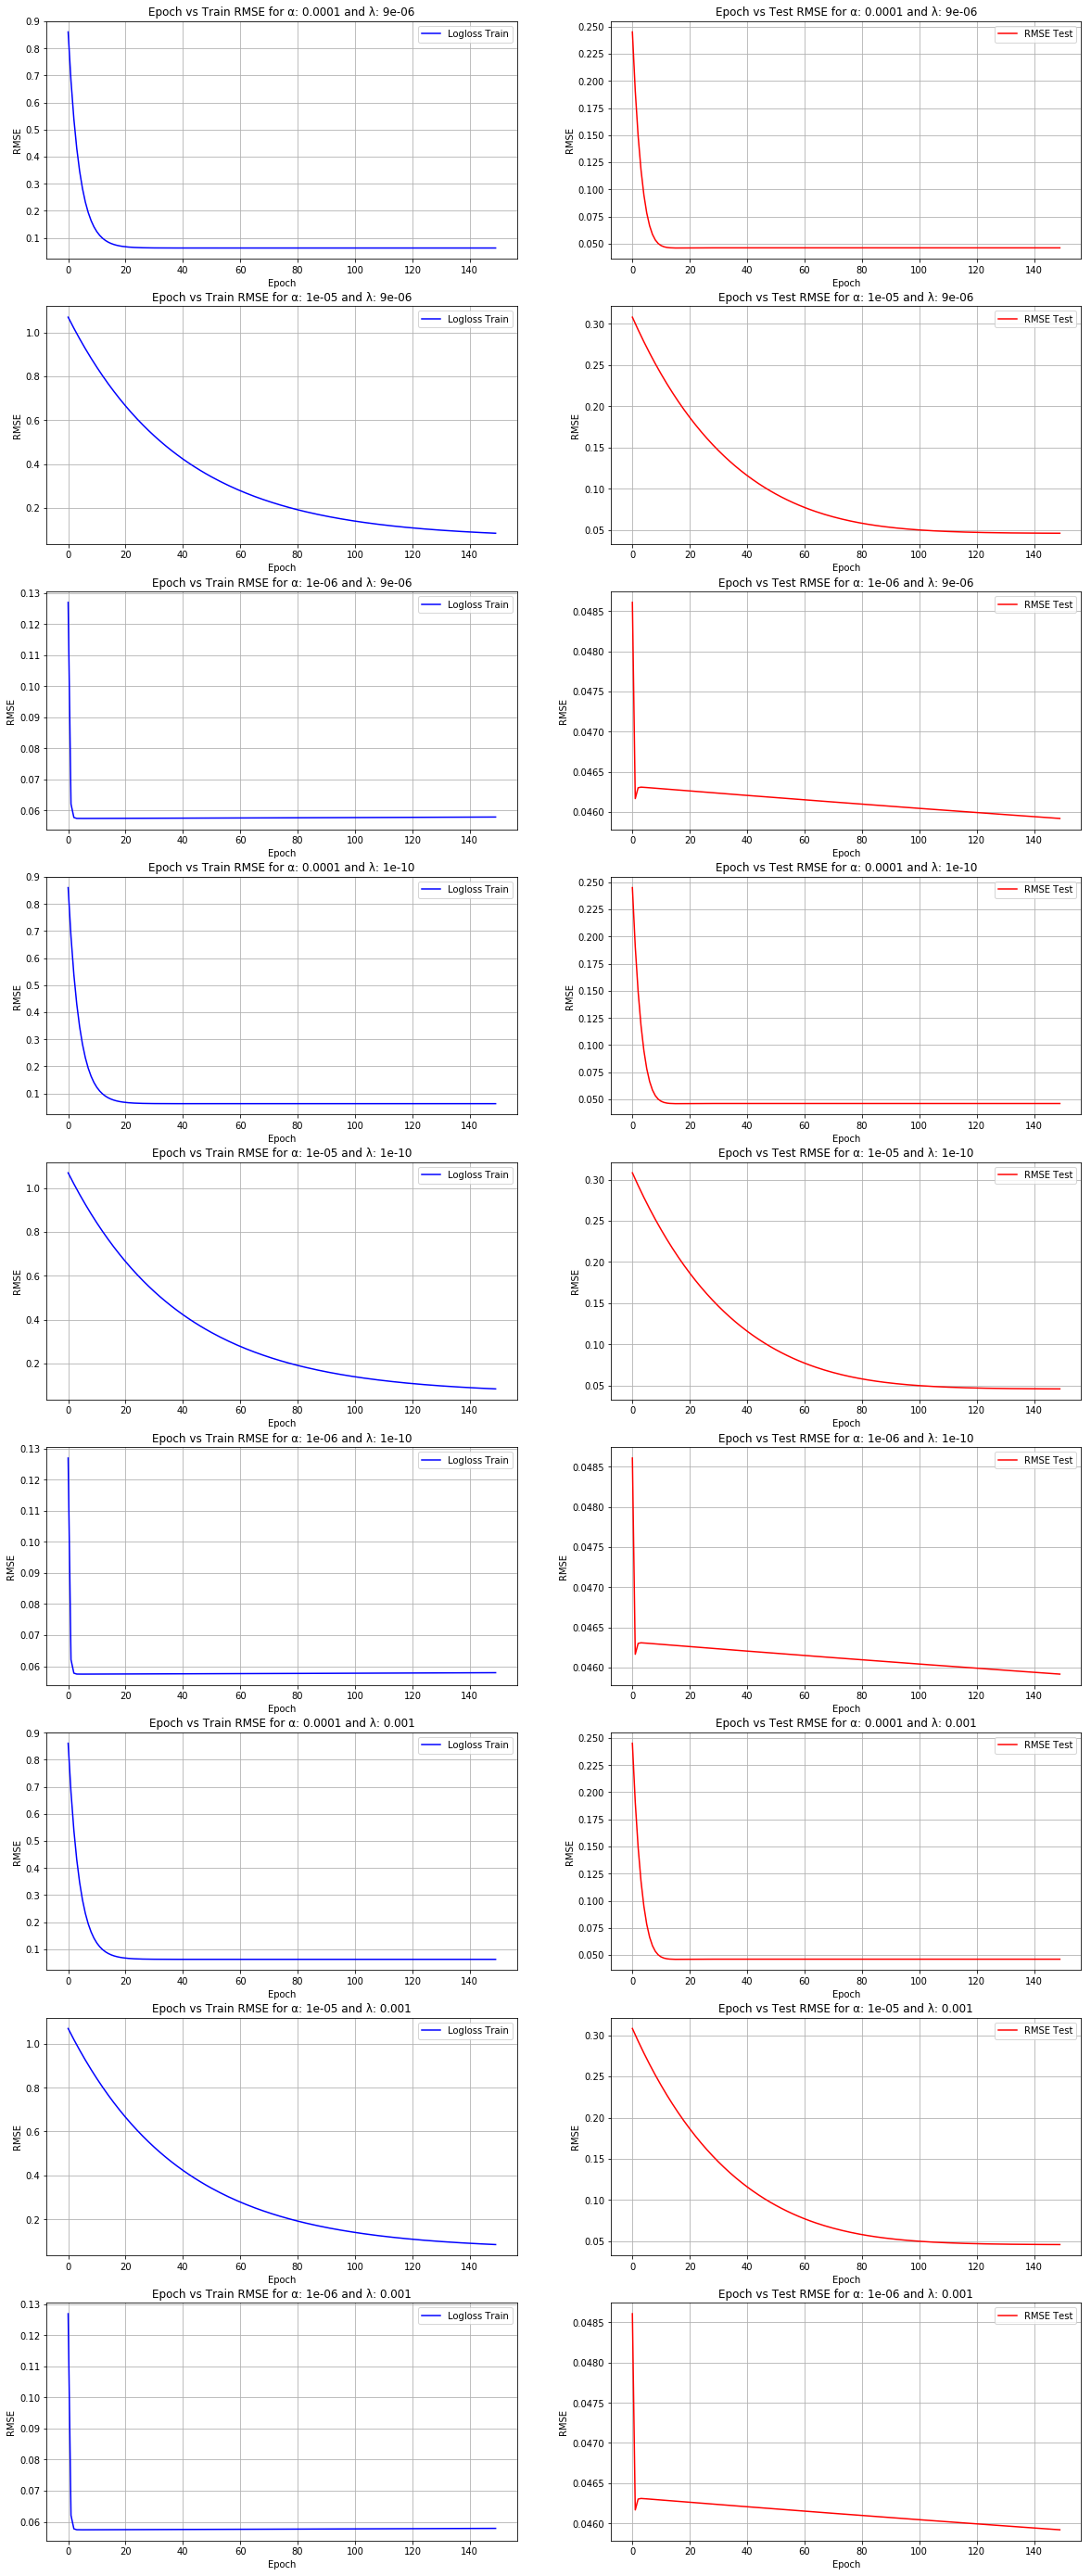

In [95]:
fig, axs = plt.subplots(9, 2, figsize=(20, 50))
i = 0
for axis in range(0,9):
    axs[axis][0].set_title('Epoch vs Train RMSE for α: '+str(alpha[i])+' and λ: '+str(reg[i]))
    axs[axis][0].plot(train_graph[i],'b',label = 'Logloss Train')
    axs[axis][0].grid()
    axs[axis][0].set_xlabel("Epoch")
    axs[axis][0].set_ylabel("RMSE")
    axs[axis][0].legend()
    axs[axis][1].set_title('Epoch vs Test RMSE for α: '+str(alpha[i])+' and λ: '+str(reg[i]))
    axs[axis][1].plot(test_graph[i],'r',label='RMSE Test')
    axs[axis][1].grid()
    axs[axis][1].set_xlabel("Epoch")
    axs[axis][1].set_ylabel("RMSE")
    axs[axis][1].legend()
    i+=1

## Hyper parameter tuning

In [49]:
def kfold(X_train,Y_train,alpha,reg,minibatchsize,fold):
    split = math.ceil(len(X_train)/fold)
    rmse_train = list()
    rmse_valid = list()
    for i in range (0,fold):
        start = i*split
        end = i*split+split
        
        if start ==0:
            fold_Xtest = X_train[start:end]
            fold_Xtrain = X_train[end:]
            fold_Ytest = Y_train[start:end]
            fold_Ytrain = Y_train[end:]
            fold_Xtrainold = fold_Xtrain
        else:
            fold_Xtest = X_train[start:end]
            fold_Xtrain1 = X_train[0:start]
            fold_Xtrain2 = X_train[end:-1]
            fold_Xtrain = np.concatenate((fold_Xtrain1,fold_Xtrain2))
            fold_Ytest = Y_train[start:end]
            fold_Ytrain1 = Y_train[0:start]
            fold_Ytrain2 = Y_train[end:-1]
            fold_Ytrain = np.concatenate((fold_Ytrain1,fold_Ytrain2))
        train_graph,valid_graph = linridgereg_gd(fold_Ytrain,fold_Ytest,fold_Xtrain,fold_Xtest,alpha,reg,minibatchsize,'Tune')
        rmse_train.append(train_graph)
        rmse_valid.append(valid_graph)
    return rmse_train,rmse_valid

In [73]:
def gridsearch(Y_train,X_train,alpha,reg,minibatchsize,fold):
    
    train_graph = list()
    valid_graph = list()
    rmse_train = list()
    rmse_valid = list()
    for i in range(0,len(reg)):
        for j in range(0,len(alpha)):
            train_graph,valid_graph = kfold(X_train,Y_train,alpha[j],reg[i],minibatchsize,fold)
            rmse_train.append(train_graph)
            rmse_valid.append(valid_graph)
    return rmse_train,rmse_valid

In [97]:
# alpha = [1e-4,5.2e-5,3.7e-3,2e-7]
# reg = [9e-16,0.01,1e-4,0.1,1e-9]
alpha = [1e-4,5.2e-5,3.7e-6,2e-7]
reg = [9e-6,0.01,1e-4,0.1,1e-9]
minibatchsize = 50
fold = 5
train_graph = list()
valid_graph = list()
train_graph,valid_graph = gridsearch(Y_train,X_train,alpha,reg,minibatchsize,fold)

In [98]:
alpha = [1e-4,5.2e-5,3.7e-6,2e-7,1e-4,5.2e-5,3.7e-6,2e-7,1e-4,5.2e-5,3.7e-6,2e-7,1e-4,5.2e-5,3.7e-6,2e-7,1e-4,5.2e-5,3.7e-6,2e-7]
reg = [9e-16,9e-16,9e-16,9e-16,0.01,0.01,0.01,0.01,1e-4,1e-4,1e-4,1e-4,0.1,0.1,0.1,0.1,1e-9,1e-9,1e-9,1e-9]

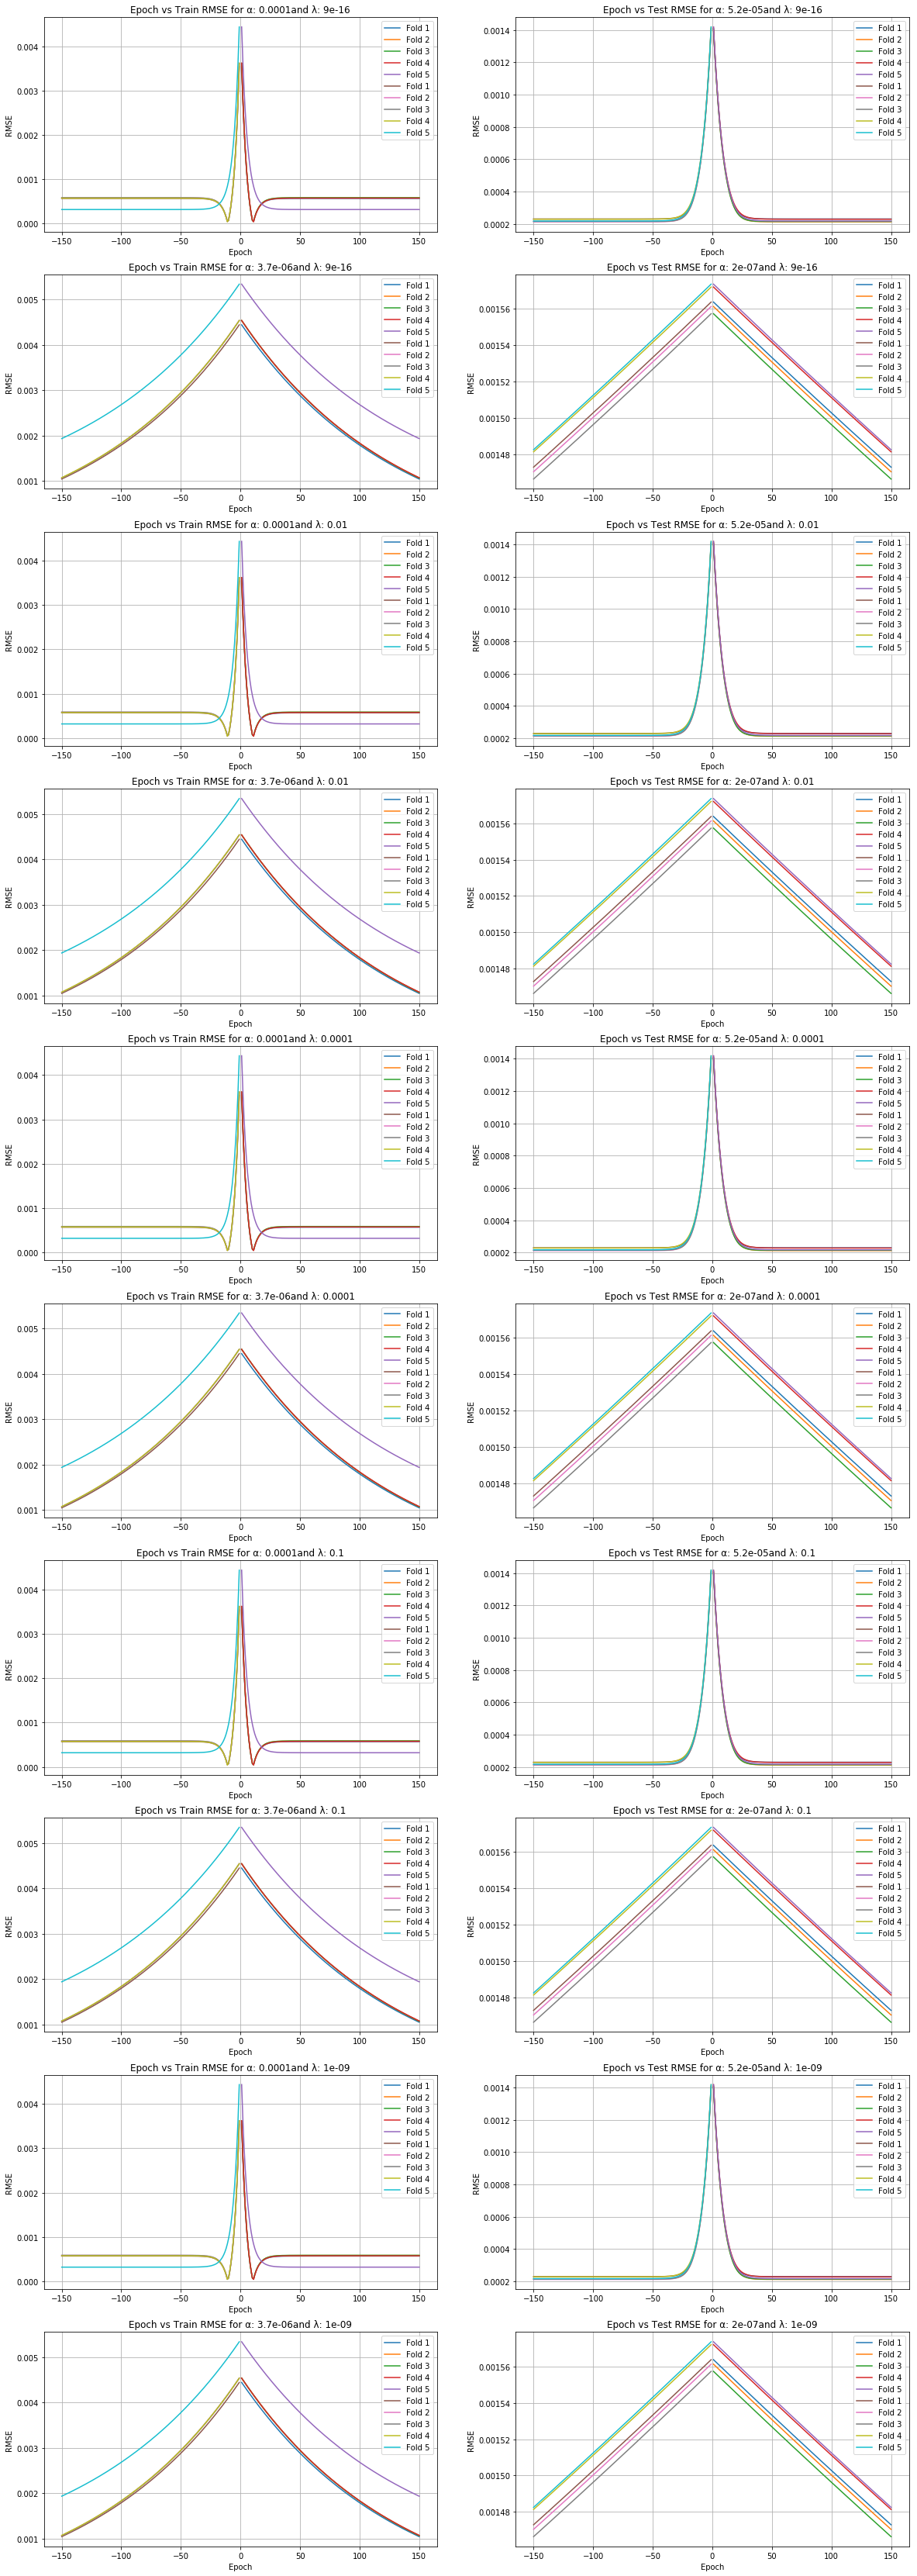

In [99]:
negrange = -np.arange(1,len(valid_graph[0][0])+1)
posrange = np.arange(1,len(valid_graph[0][0])+1)
fig, axs = plt.subplots(10, 2, figsize=(20, 60))
i = 0
for axis in range(0,10):
    axs[axis][0].set_title('Epoch vs Train RMSE for α: '+str(alpha[i])+'and λ: '+str(reg[i]))
    axs[axis][0].plot(posrange,train_graph[i][0],label = 'Fold 1')
    axs[axis][0].plot(posrange,train_graph[i][1],label = 'Fold 2')
    axs[axis][0].plot(posrange,train_graph[i][2],label = 'Fold 3')
    axs[axis][0].plot(posrange,train_graph[i][3],label = 'Fold 4')
    axs[axis][0].plot(posrange,train_graph[i][4],label = 'Fold 5')
    axs[axis][0].plot(negrange,train_graph[i][0],label = 'Fold 1')
    axs[axis][0].plot(negrange,train_graph[i][1],label = 'Fold 2')
    axs[axis][0].plot(negrange,train_graph[i][2],label = 'Fold 3')
    axs[axis][0].plot(negrange,train_graph[i][3],label = 'Fold 4')
    axs[axis][0].plot(negrange,train_graph[i][4],label = 'Fold 5')
    axs[axis][0].grid()
    axs[axis][0].set_xlabel("Epoch")
    axs[axis][0].set_ylabel("RMSE")
    axs[axis][0].legend()
    i+=1
    axs[axis][1].set_title('Epoch vs Test RMSE for α: '+str(alpha[i])+'and λ: '+str(reg[i]))
    axs[axis][1].plot(posrange,valid_graph[i][0],label = 'Fold 1')
    axs[axis][1].plot(posrange,valid_graph[i][1],label = 'Fold 2')
    axs[axis][1].plot(posrange,valid_graph[i][2],label = 'Fold 3')
    axs[axis][1].plot(posrange,valid_graph[i][3],label = 'Fold 4')
    axs[axis][1].plot(posrange,valid_graph[i][4],label = 'Fold 5')
    axs[axis][1].plot(negrange,valid_graph[i][0],label = 'Fold 1')
    axs[axis][1].plot(negrange,valid_graph[i][1],label = 'Fold 2')
    axs[axis][1].plot(negrange,valid_graph[i][2],label = 'Fold 3')
    axs[axis][1].plot(negrange,valid_graph[i][3],label = 'Fold 4')
    axs[axis][1].plot(negrange,valid_graph[i][4],label = 'Fold 5')
    axs[axis][1].grid()
    axs[axis][1].set_xlabel("Epoch")
    axs[axis][1].set_ylabel("RMSE")
    axs[axis][1].legend()
    i+=1

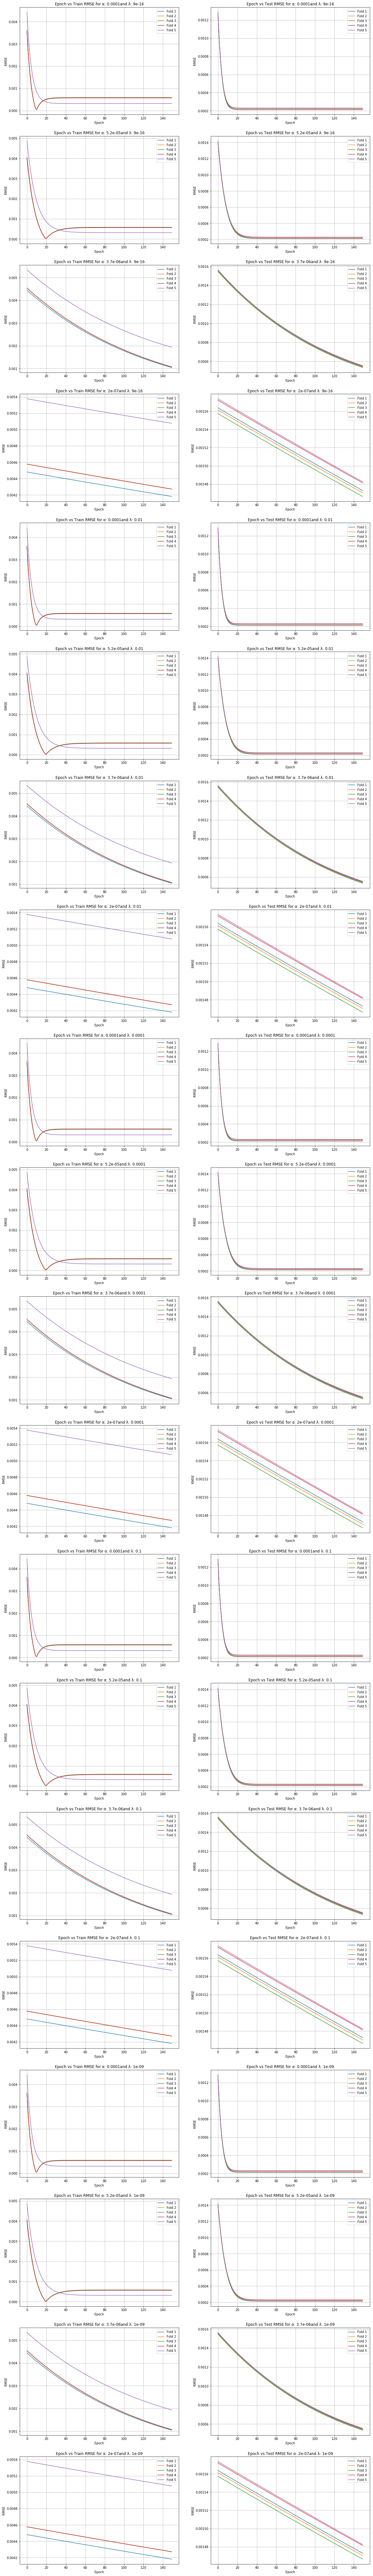

In [101]:
fig, axs = plt.subplots(20, 2, figsize=(20, 150))
i = 0
for axis in range(0,20):
    axs[axis][0].set_title('Epoch vs Train RMSE for α: '+str(alpha[i])+'and λ: '+str(reg[i]))
    axs[axis][0].plot(train_graph[i][0],label = 'Fold 1')
    axs[axis][0].plot(train_graph[i][1],label = 'Fold 2')
    axs[axis][0].plot(train_graph[i][2],label = 'Fold 3')
    axs[axis][0].plot(train_graph[i][3],label = 'Fold 4')
    axs[axis][0].plot(train_graph[i][4],label = 'Fold 5')
    axs[axis][0].grid()
    axs[axis][0].set_xlabel("Epoch")
    axs[axis][0].set_ylabel("RMSE")
    axs[axis][0].legend()
    axs[axis][1].set_title('Epoch vs Test RMSE for α: '+str(alpha[i])+'and λ: '+str(reg[i]))
    axs[axis][1].plot(valid_graph[i][0],label = 'Fold 1')
    axs[axis][1].plot(valid_graph[i][1],label = 'Fold 2')
    axs[axis][1].plot(valid_graph[i][2],label = 'Fold 3')
    axs[axis][1].plot(valid_graph[i][3],label = 'Fold 4')
    axs[axis][1].plot(valid_graph[i][4],label = 'Fold 5')
    axs[axis][1].grid()
    axs[axis][1].set_xlabel("Epoch")
    axs[axis][1].set_ylabel("RMSE")
    axs[axis][1].legend()
    i+=1

In [78]:
rmse = list()
for i in range(0,len(train_graph)):
    average = 0
    for j in range(0,len(train_graph[i])):
        average += (train_graph[i][j][-1])
    average = average/5
    if math.isnan(average):
        average = 0
    else:
        rmse.append(average)

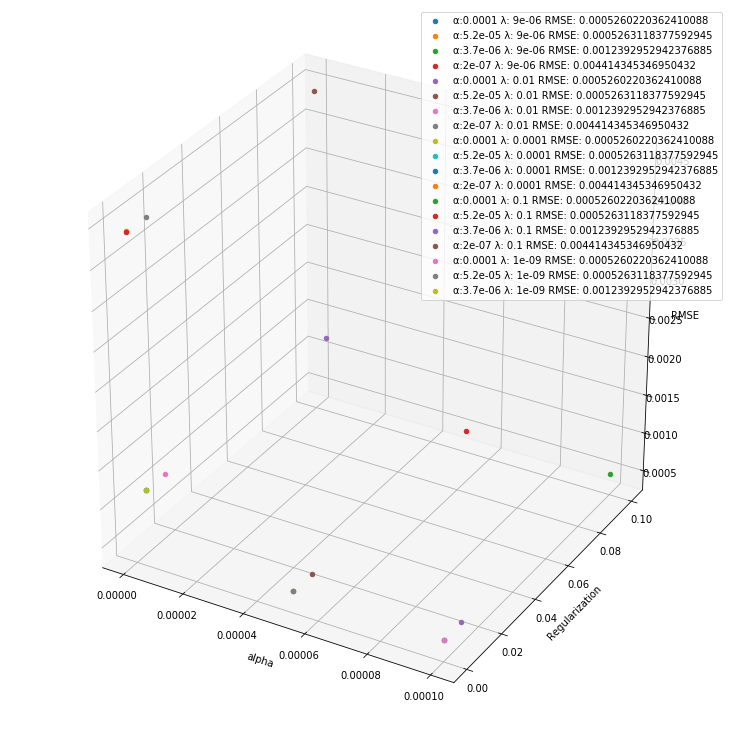

Best Model using Grid search with k-fold cross validation:
	α: 0.0001
	λ: 9e-06
	RMSE: 0.0005260220362410088


In [110]:
fig = plt.figure(figsize = (10,10))
ax = Axes3D(fig)
alpha = [1e-4,5.2e-5,3.7e-6,2e-7,1e-4,5.2e-5,3.7e-6,2e-7,1e-4,5.2e-5,3.7e-6,2e-7,1e-4,5.2e-5,3.7e-6,2e-7,1e-4,5.2e-5,3.7e-6,2e-7]
reg = [9e-6,9e-6,9e-6,9e-6,0.01,0.01,0.01,0.01,1e-4,1e-4,1e-4,1e-4,0.1,0.1,0.1,0.1,1e-9,1e-9,1e-9,1e-9]
for i in range(0,19):
    ax.scatter(xs=alpha[i], ys=reg[i], zs=rmse[i], zdir='z', label="α:"+str(alpha[i])+" λ: "+str(reg[i])+" RMSE: "+str(rmse[i]))
ax.set_xlabel("alpha")
ax.set_ylabel("Regularization")
ax.set_zlabel("RMSE")
ax.legend()
plt.show()

i = rmse.index(min(rmse))
print("Best Model using Grid search with k-fold cross validation:\n\tα: "+str(alpha[i])+"\n\tλ: "+str(reg[i])+"\n\tRMSE: "+str(rmse[i]))


In [111]:
alpha = [1e-4]
reg = [9e-6]
minibatchsize = 50
train_graph = list()
test_graph = list()
train_graph,test_graph = linridgereg_gd(Y_train,Y_test,X_train,X_test,alpha,reg,minibatchsize,None)
train_graph = denormalise_data(redwinedata,train_graph)
test_graph = denormalise_data(redwinedata,test_graph)

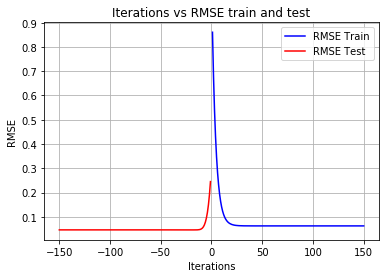

In [113]:
negrange = -np.arange(1,len(test_graph[0])+1)
posrange = np.arange(1,len(test_graph[0])+1)
plt.plot(posrange,train_graph[0],'b',label = 'RMSE Train')
plt.plot(negrange,test_graph[0],'r',label = 'RMSE Test')
plt.xlabel("Iterations")
plt.ylabel("RMSE")
plt.legend()
plt.title("Iterations vs RMSE train and test")
plt.grid()

In [109]:
train_graph

[[0.8605454231291336,
  0.679064052131266,
  0.5388532059018148,
  0.4305276046889134,
  0.34683626440066423,
  0.2821771387812993,
  0.2322221361856418,
  0.19362741081123075,
  0.16380953626382963,
  0.1407725792898568,
  0.12297449858565714,
  0.1092239258449138,
  0.09860041984062459,
  0.09039285550860168,
  0.08405182389636551,
  0.0791528567193763,
  0.07536801388333525,
  0.07244393216448303,
  0.0701848657485662,
  0.0684395834656761,
  0.0670912456985768,
  0.06604958337556807,
  0.06524485554047149,
  0.064623181037117,
  0.06414293182127632,
  0.0637719464742817,
  0.0634853773948867,
  0.06326402756337351,
  0.06309306554336556,
  0.06296103270568586,
  0.06285907621965674,
  0.06278035646984645,
  0.06271958923205663,
  0.06267269196290419,
  0.06263651052651507,
  0.06260860806613787,
  0.06258710188831786,
  0.06257053744111667,
  0.0625577909508447,
  0.06254799420008887,
  0.06254047641190348,
  0.0625347193500643,
  0.06253032262993156,
  0.06252697691793585,
  0.062